In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import shap

# To scale the data using Standard Scaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

import scipy.stats as stats

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

os.getcwd()

'/content'

In [3]:
hm = pd.read_csv('loan_dataset.csv')
data = hm.copy()
print(data.head())
print("---------")
print(data.tail())
print("---------")
data.shape

   BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN  
---------
      BAD   LOAN  MORTDUE    VALUE   REASON    JOB   YOJ  DEROG  DELINQ  \
5955    0  88900  57264.0  90185.0  DebtCon  Other  16.0    0.0     0.0   
5956    0  89000  54576.0  92937.0  DebtCon  Other  16.0    0.0     0.0   
5957    0  89200  54045.0  92924.0  DebtCon  Other  15.0    0.0     0.0   
5958    0  89800  50370.0  91

(5960, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [5]:
data.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


In [6]:
# Checking the percentage of missing values in the each column.
(data.isnull().sum()/data.shape[0] * 100)

,0
BAD,0.000000
LOAN,0.000000
MORTDUE,8.691275
VALUE,1.879195
REASON,4.228188
JOB,4.681208
YOJ,8.640940
DEROG,11.879195
DELINQ,9.731544
CLAGE,5.167785


In [7]:
cols = data.select_dtypes(['object']).columns.tolist()

#adding target variable to this list as this is a classification problem and the target variable is categorical

cols.append('BAD')
cols

['REASON', 'JOB', 'BAD']

In [8]:
# Changing the data type of object type column to category.

for i in cols:
    data[i] = data[i].astype("category")
data.info()

'''object is converted to category type.'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   category
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5442 non-null   float64 
 3   VALUE    5848 non-null   float64 
 4   REASON   5708 non-null   category
 5   JOB      5681 non-null   category
 6   YOJ      5445 non-null   float64 
 7   DEROG    5252 non-null   float64 
 8   DELINQ   5380 non-null   float64 
 9   CLAGE    5652 non-null   float64 
 10  NINQ     5450 non-null   float64 
 11  CLNO     5738 non-null   float64 
 12  DEBTINC  4693 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 483.7 KB


'object is converted to category type.'

In [9]:
# Analyzing the summary statistics for numerical variables

num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000
DEBTINC,4693.0,33.779915,8.601746,0.524499,29.140031,34.818262,39.003141,203.312149


Insights-

LOAN: The "LOAN" column represents the loan amount requested by the client. The mean loan amount is approximately 18,608 with a wide range of values. The highest loan amount is approximately 89,900.

MORTDUE: The "MORTDUE" column represents the amount of the existing mortgage due for the property. There are missing values in this column. The mean mortgage due is approximately 73,761.

VALUE: The "VALUE" column represents the value of the property. The mean property value is approximately 101,776, with a wide range of values. The highest property value is 855,909.

YOJ: The "YOJ" column represents the number of years in the job for the client. The mean years in the job is approximately 8.92 years.

DEROG: The "DEROG" column represents the number of major derogatory reports on the client's credit history. The mean number of derogatory reports is approximately 0.25.

DELINQ: The "DELINQ" column represents the number of delinquent credit lines on the client's credit history. The mean number of delinquent credit lines is approximately 0.45.

CLAGE: The "CLAGE" column represents the age of the oldest trade line in months. The mean age of the oldest trade line is approximately 179.77 months.

NINQ: The "NINQ" column represents the number of recent credit lines on the client's credit history. The mean number of recent credit lines is approximately 1.19.

CLNO: The "CLNO" column represents the number of credit lines on the client's credit history. The mean number of credit lines is approximately 21.30.

DEBTINC: The "DEBTINC" column represents the debt-to-income ratio for the client. The mean debt-to-income ratio is approximately 33.78.

In [10]:
data.describe(include=['category']).T

,count,unique,top,freq
BAD,5960,2,0,4771
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


Insights-

BAD: The "BAD" column represents whether a client defaulted (value is 1) or did not defaulted (value 0) and has a frequency of 80%. This means the other 20% of clients have defaulted at least once.

REASON: The "REASON" column represents the reason for the loan, with two unique values: "DebtCon" (Debt Consolidation) and "HomeImp" (Home Improvement). The most common reason for the loan is debt consolidation (DebtCon).

JOB: The "JOB" column represents the job type of the client. There are six unique job types, with "Other" being the most common job type.

In [11]:
# Checking the count of unique values in each categorical column

cols_cat= data.select_dtypes(['category'])

for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(data[i].value_counts(normalize = True))
    print('*'*40)

Unique values in BAD are :
BAD
0    0.800503
1    0.199497
Name: proportion, dtype: float64
****************************************
Unique values in REASON are :
REASON
DebtCon    0.688157
HomeImp    0.311843
Name: proportion, dtype: float64
****************************************
Unique values in JOB are :
JOB
Other      0.420349
ProfExe    0.224608
Office     0.166872
Mgr        0.135011
Self       0.033973
Sales      0.019187
Name: proportion, dtype: float64
****************************************


Insights-

80% of client are non defaulted. 20% of them are defaulted.
Around 69% ask for loans to pay other liabilities and consumer debts. ~30% ask for loans to make home improvements.
There are six types of jobs: ~58% of those jobs are proffesional executives, Office employees, Managers, self employed, sales. The 42% is in Other job.

Exploratory Data Analysis (EDA) and Visualization¶
Leading Questions:

What is the range of values for the loan amount variable "LOAN"?
How does the distribution of years at present job "YOJ" vary across the dataset?
How many unique categories are there in the REASON variable?
What is the most common category in the JOB variable?
Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
Do applicants who default have a significantly different loan amount compared to those who repay their loan?
Is there a correlation between the value of the property and the loan default rate?
Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### Univariate Analysis

The percentage of defaulters in the data is BAD
0    80.050336
1    19.949664
Name: count, dtype: float64 %


[]

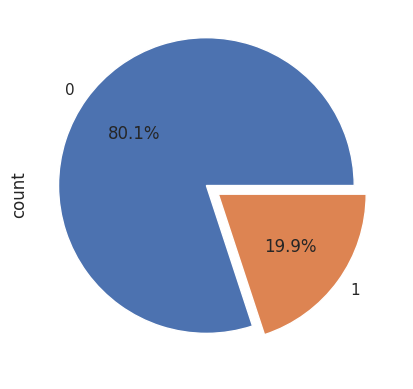

In [12]:
# How many defaulters
perc_default = data['BAD'].value_counts() / len(data['BAD'])
print(f'The percentage of defaulters in the data is {perc_default*100} %')
data['BAD'].value_counts().plot(kind='pie',explode=[0.1,0],autopct="%1.1f%%")
plt.plot()

In [13]:
def show_value_counts(col):
    print(col)
    value_counts = data[col].value_counts()
    percentage = value_counts / len(data) * 100
    result_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts, 'Percentage': percentage})
    result_df = result_df.sort_values(by='Value')
    print(result_df)
    print('--------------------------')
    generate_pie_plot(result_df)


def generate_pie_plot(data_frame):
    plt.figure(figsize=(6, 5))
    plt.pie(data_frame['Count'], labels=data_frame['Value'], autopct='%1.1f%%')
    plt.axis('equal')
    plt.show()

REASON
           Value  Count  Percentage
REASON                             
DebtCon  DebtCon   3928   65.906040
HomeImp  HomeImp   1780   29.865772
--------------------------


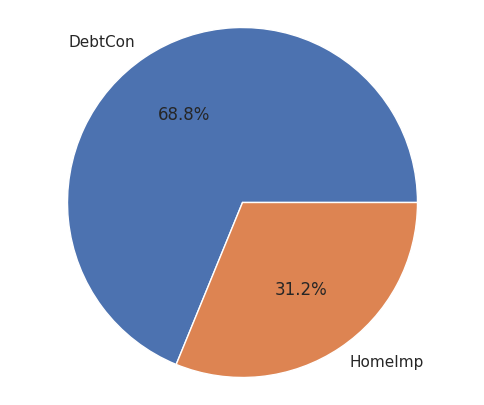

In [14]:
#Show unique categories in the REASON variable
show_value_counts('REASON')

JOB
           Value  Count  Percentage
JOB                                
Mgr          Mgr    767   12.869128
Office    Office    948   15.906040
Other      Other   2388   40.067114
ProfExe  ProfExe   1276   21.409396
Sales      Sales    109    1.828859
Self        Self    193    3.238255
--------------------------


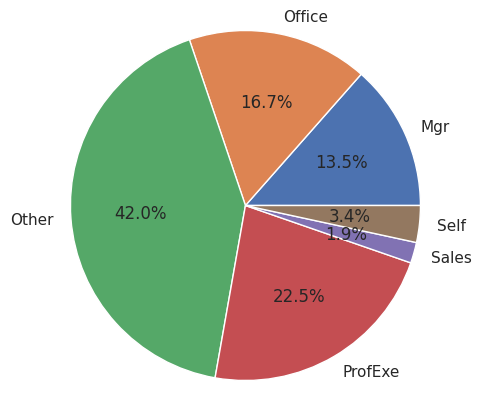

In [15]:
#Show unique categories in the JOB variable
show_value_counts('JOB')

LOAN
Skew : 2.02


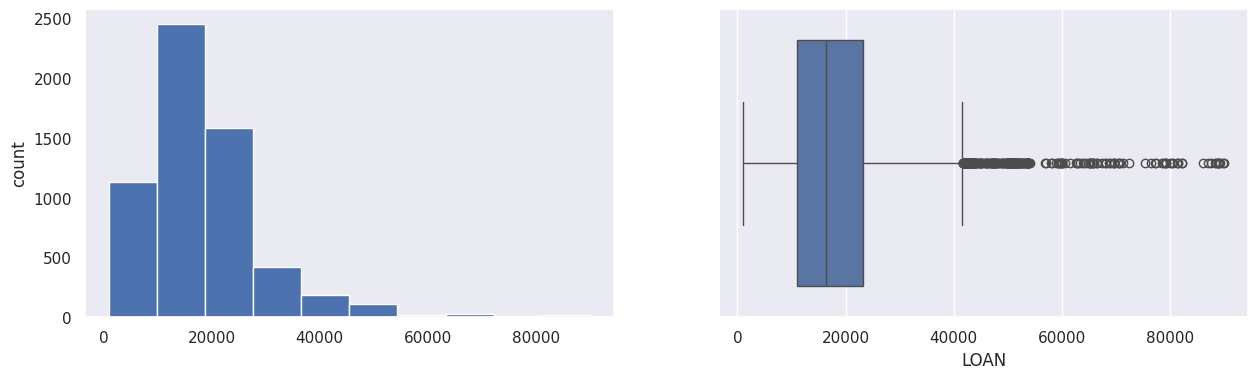

MORTDUE
Skew : 1.81


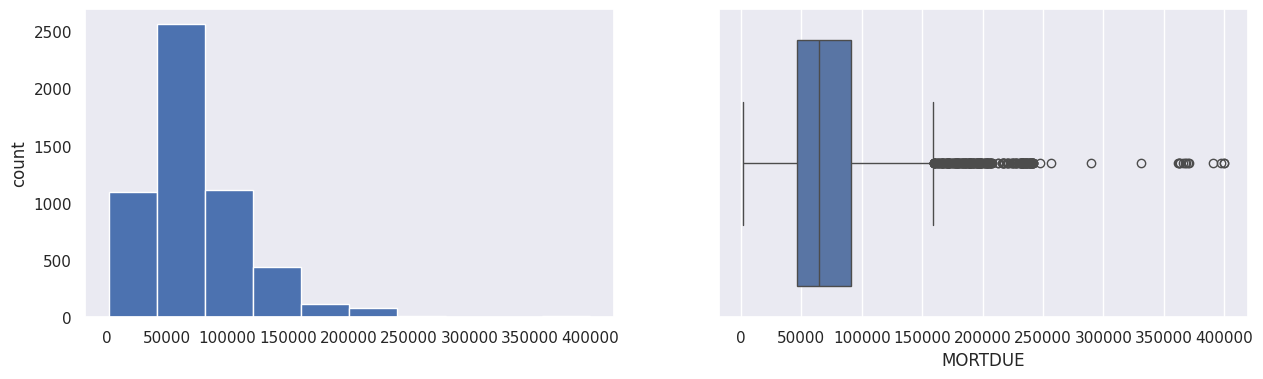

VALUE
Skew : 3.05


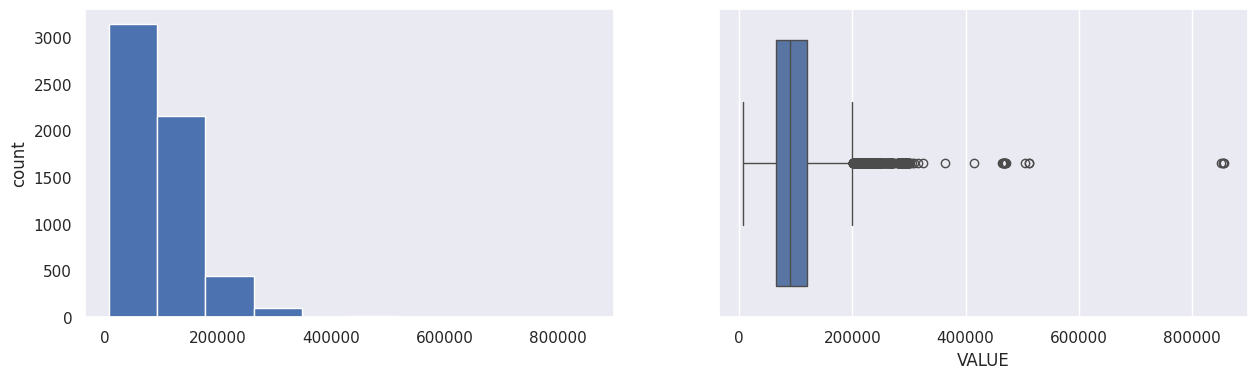

YOJ
Skew : 0.99


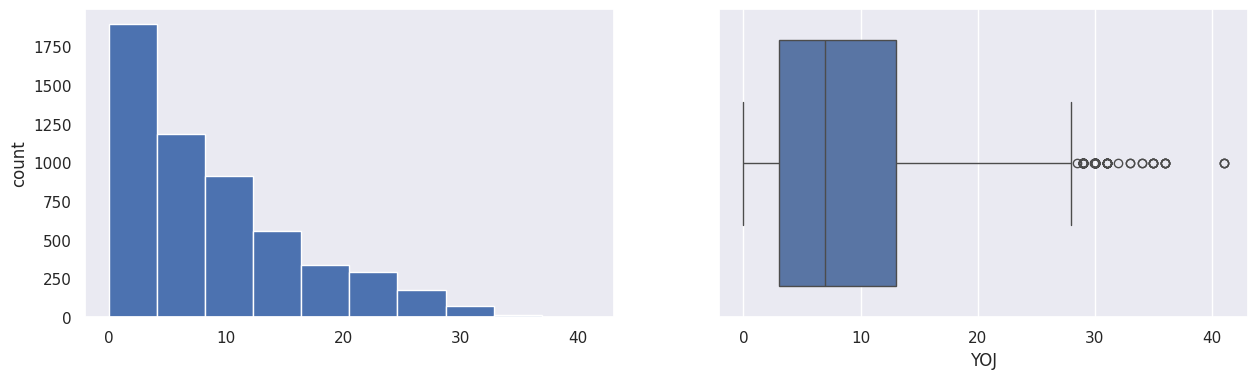

DEROG
Skew : 5.32


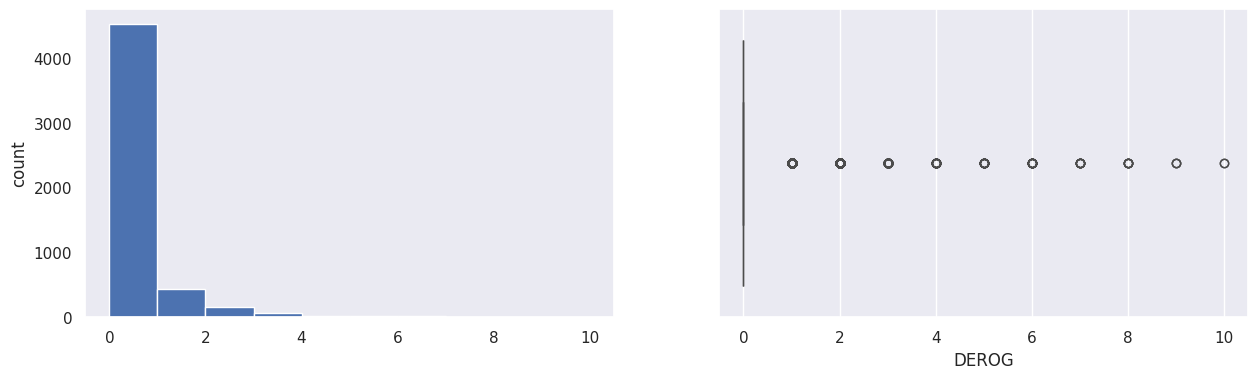

DELINQ
Skew : 4.02


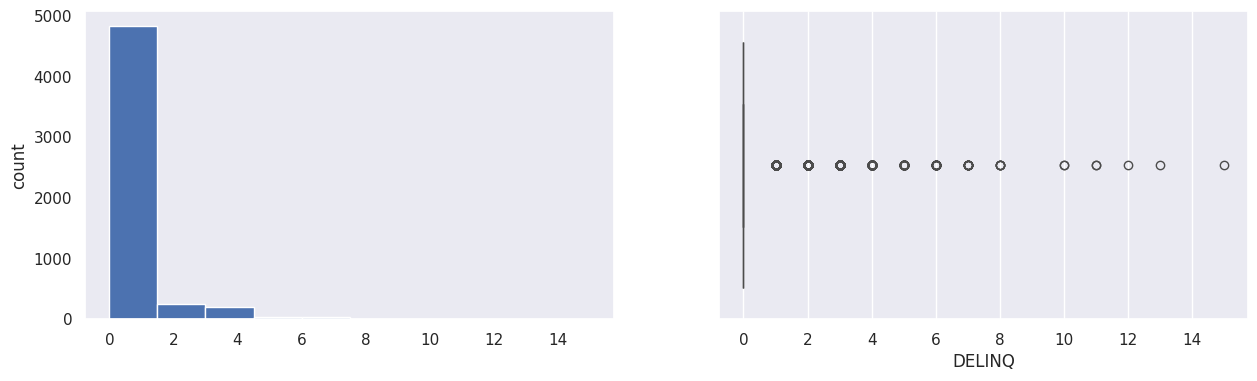

CLAGE
Skew : 1.34


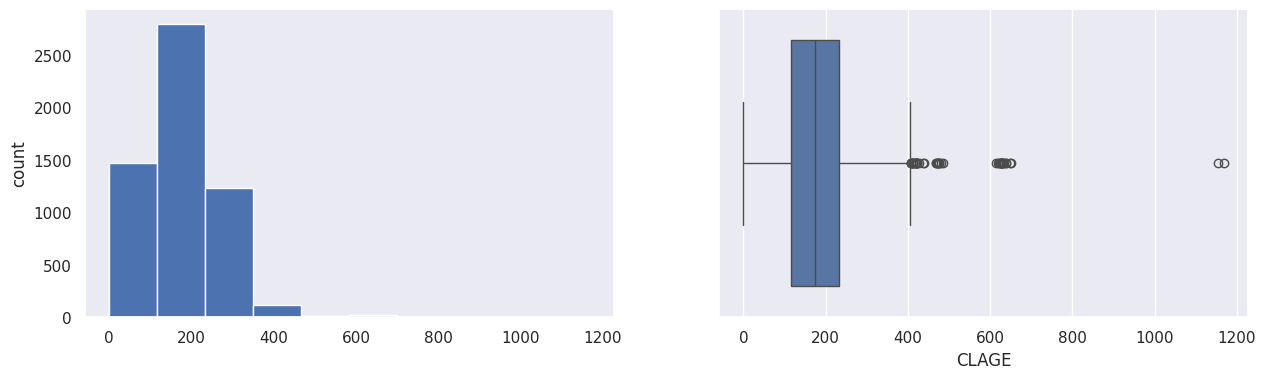

NINQ
Skew : 2.62


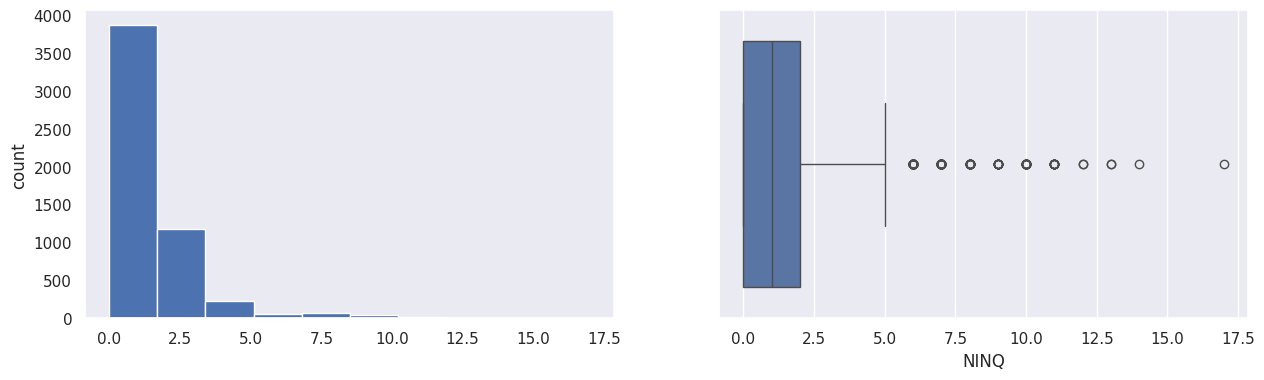

CLNO
Skew : 0.78


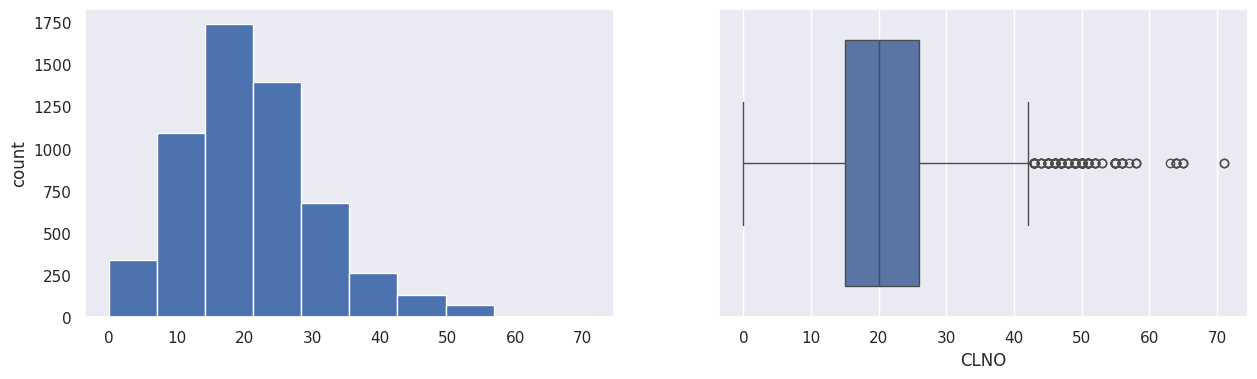

DEBTINC
Skew : 2.85


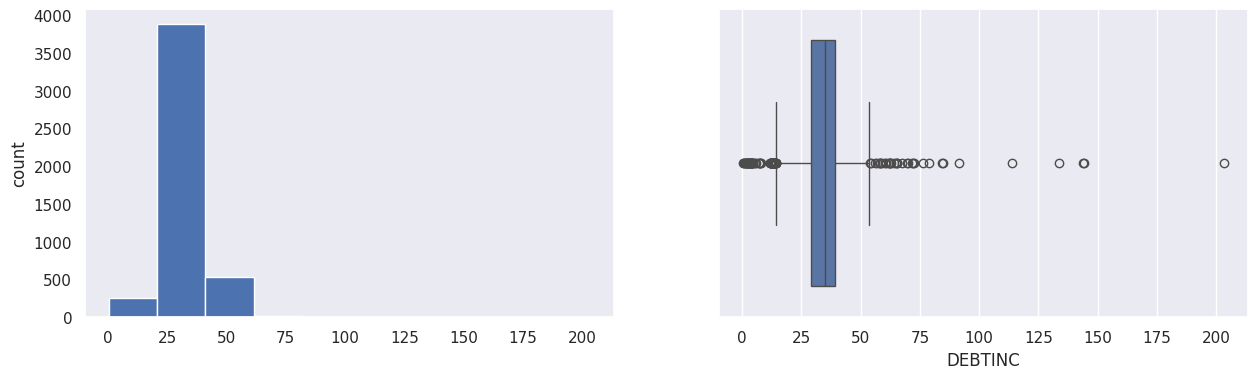

In [16]:
#histogram and boxplot of numerical variables
for feature in num_cols:
    print(feature)

    print('Skew :',round(data[feature].skew(), 2))

    plt.figure(figsize = (15, 4))

    plt.subplot(1, 2, 1)

    data[feature].hist(bins = 10, grid = False)

    plt.ylabel('count')

    plt.subplot(1, 2, 2)

    sns.boxplot(x = data[feature])

    plt.show()

Observations:

LOAN, MORTDUE, VALUE, CLNO, DEBTINC variables have outliers.

DEBTINC normal shape distribution that shows outliers on the right and left ends.

The variable LOAN has a skewed distribution to the right with lot of big outliers compared to the mean.

The variable YOG is very skewed to the right and has a few outliers.

<Axes: xlabel='BAD', ylabel='LOAN'>

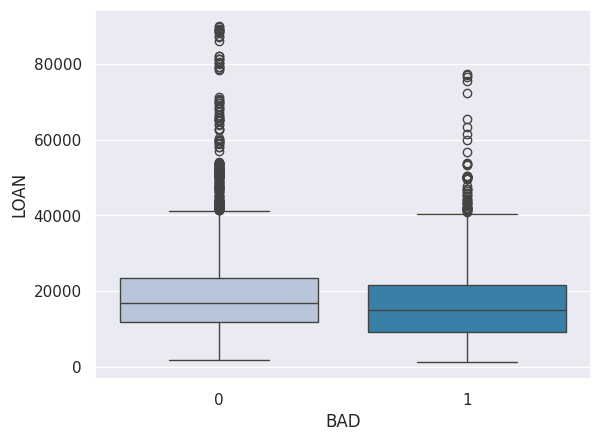

In [17]:
#Analyze BAD vs Loan
sns.boxplot(x=data["BAD"],y=data['LOAN'],palette="PuBu")

Insight: it seems that bothe type of client (defaulted or not) receive the same amount of loans



<Axes: xlabel='BAD', ylabel='MORTDUE'>

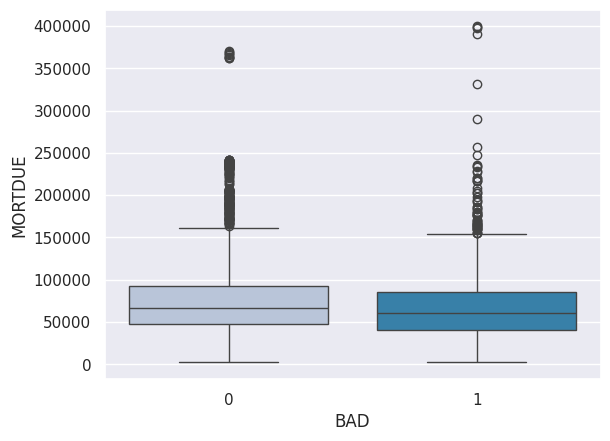

In [18]:
#Analyze BAD vs MORTDUE
sns.boxplot(x=data["BAD"],y=data['MORTDUE'],palette="PuBu")

<Axes: xlabel='VALUE', ylabel='MORTDUE'>

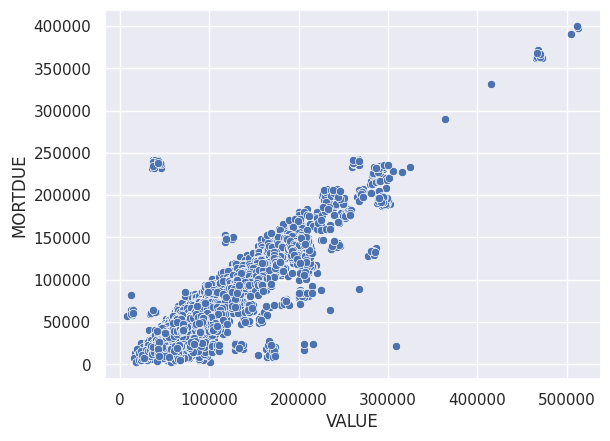

In [19]:
#scatterplot VALUE vs MORTDUE
sns.scatterplot(x=data["VALUE"],y=data['MORTDUE'],palette="PuBu")

Insights:

There is a linear correlation between the variables VALUE and MORTDUE.

<Axes: xlabel='LOAN', ylabel='VALUE'>

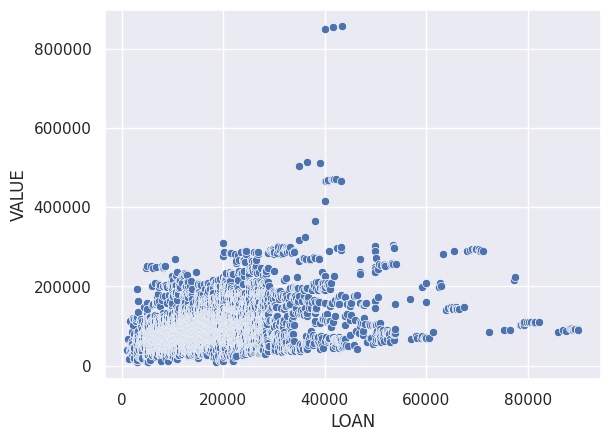

In [20]:
#scatterplot VALUE vs LOAN
sns.scatterplot(x=data["LOAN"],y=data['VALUE'],palette="PuBu")

Insights:

There is a no correlation between the value of the property and the loan default rate.

In [21]:
### Function to plot stacked bar charts for categorical columns
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=0)
    plt.show()

BAD         0     1   All
REASON                   
All      4567  1141  5708
DebtCon  3183   745  3928
HomeImp  1384   396  1780
------------------------------------------------------------------------------------------------------------------------


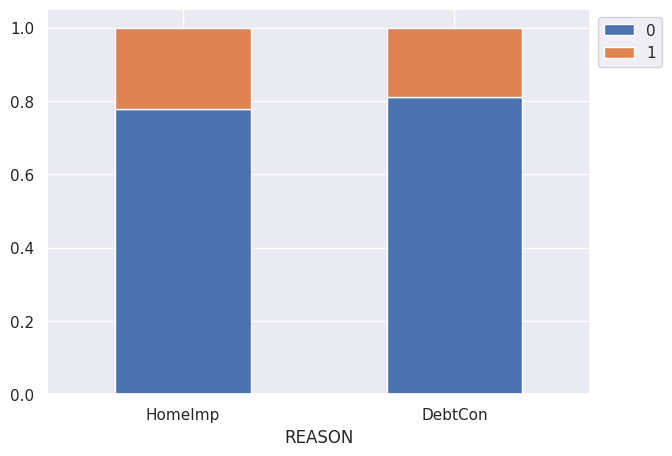

In [22]:
stacked_barplot(data, "REASON", "BAD")

Observation:

Both reason debt consolidation or home improvement have no such difference on loan defaulter or not

### **MULTIVARIATE ANALYSIS**

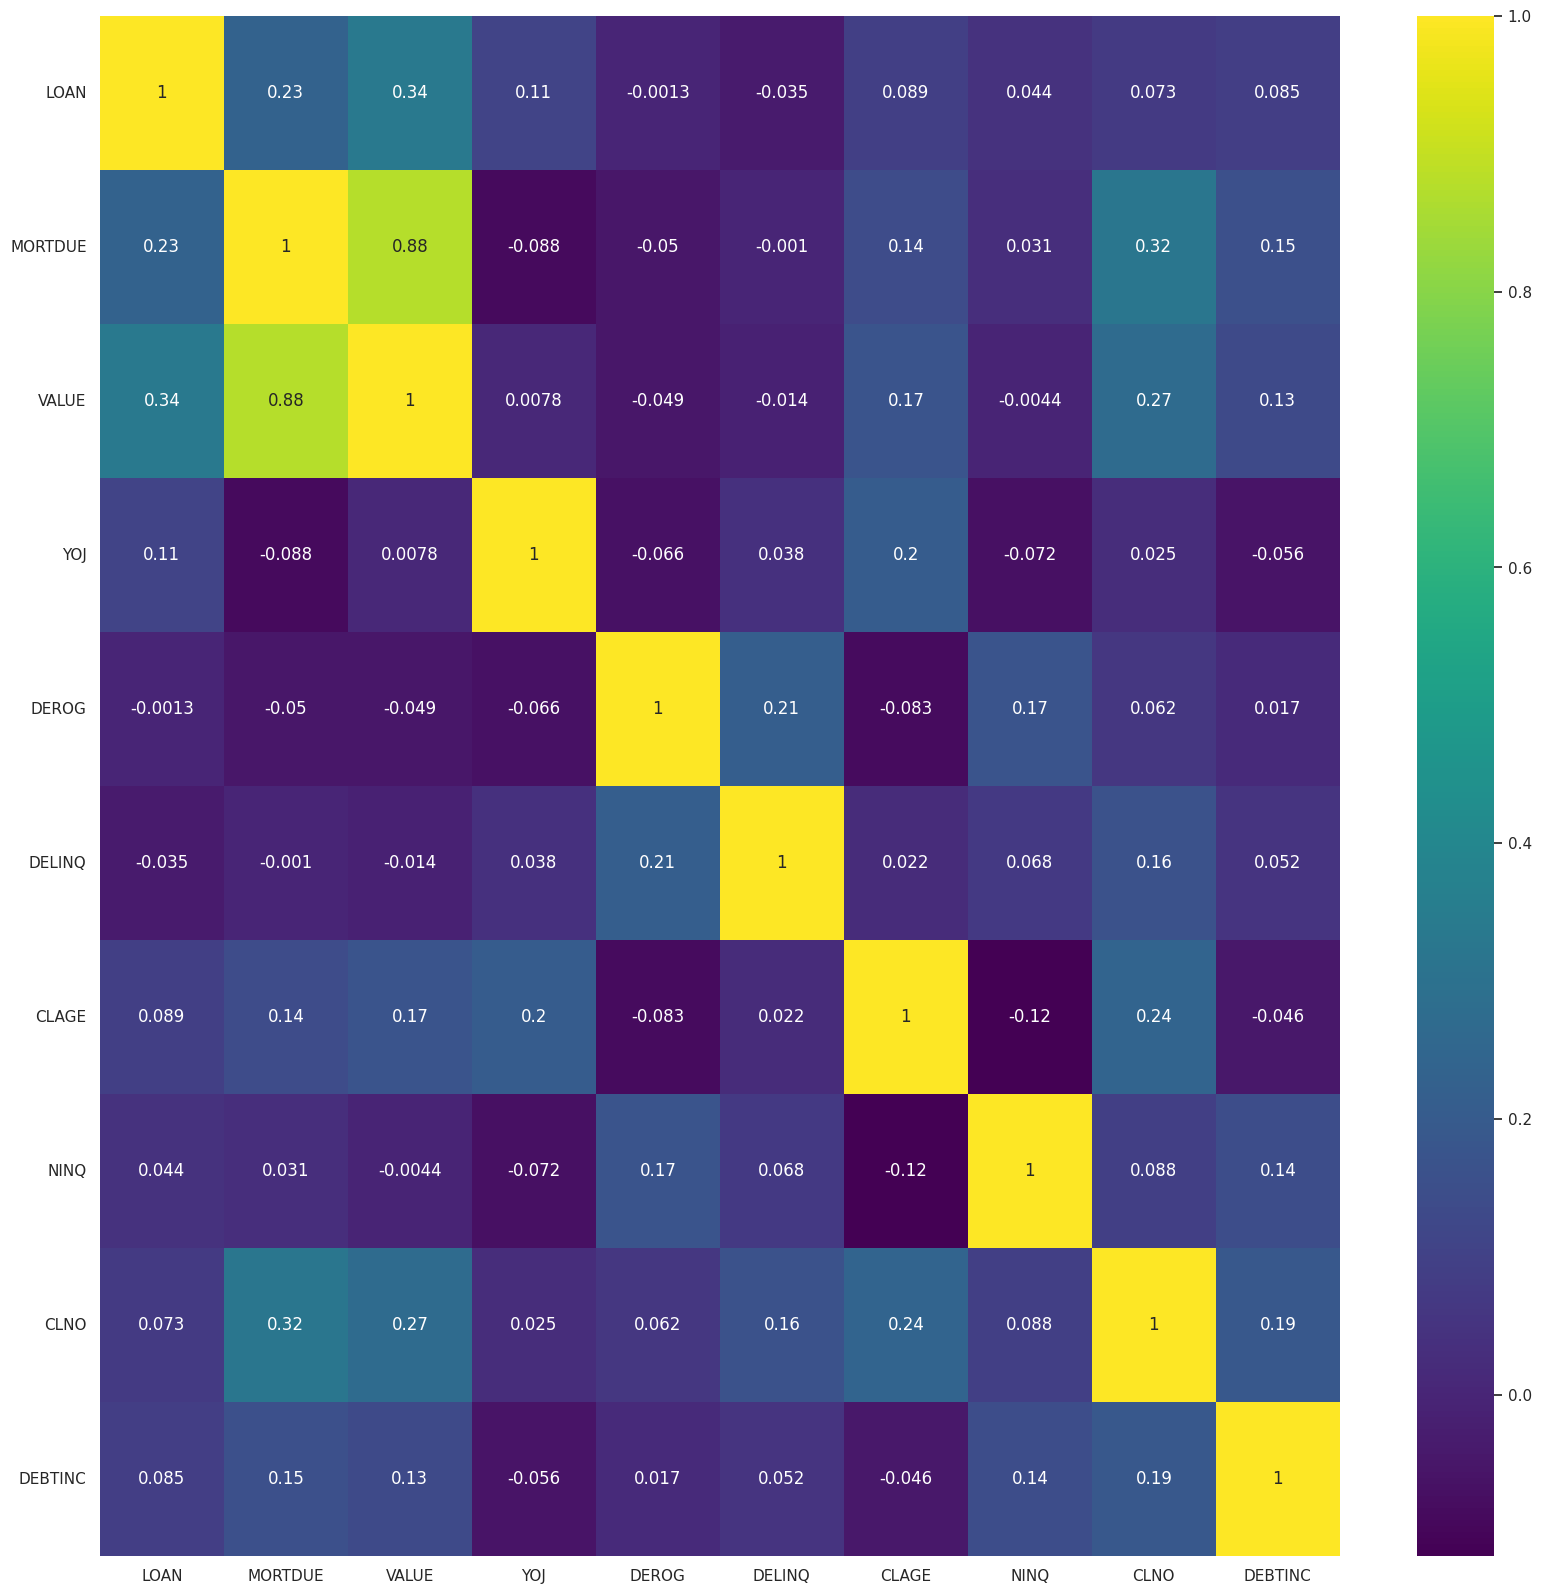

In [23]:
# Create a figure and plot the heatmap
plt.figure(figsize=(20, 20))
heat_map = sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="viridis")
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

### **TREATING OUTLIERS**

In [24]:
#function to treat outliers
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame

    '''

    Q1=df[col].quantile(q = .25) # 25th quantile
    Q3=df[col].quantile(q = .75)  # 75th quantile
    IQR = Q3-Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)

    return df

arr = np.array([2, 5, 10, 15, 20])

clipped = np.clip(arr, 5, 15)

o/p: [ 5  5 10 15 15 ]


In [25]:
#copy data
df_raw = data.copy()

numerical_col = df_raw.select_dtypes(include=np.number).columns.tolist()# getting list of numerical columns

df = treat_outliers_all(df_raw,numerical_col)

In [26]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,41600,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,41600,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,41600,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,41600,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


### Treating Missing Values

In [27]:
#For each column we create a binary flag for the row, if there is missing value in the row, then 1 else 0.Adding new columns in the dataset for each column which has missing values
def add_binary_flag(df,col):
    '''
    df: It is the dataframe
    col: it is column which has missing values
    It returns a dataframe which has binary falg for missing values in column col
    '''
    new_col = str(col)
    new_col += '_missing_values_flag'
    df[new_col] = df[col].isna().astype(int)
    return df

In [28]:
# list of columns that has missing values in it
missing_col = [col for col in df.columns if df[col].isnull().any()]

for colmn in missing_col:
    add_binary_flag(df,colmn)

Filling missing values in numerical columns with median and mode in categorical variables

In [29]:
#  Treating Missing values in numerical columns with median and mode in categorical variables
# Select numeric columns.
num_data = df.select_dtypes('number')

# Selecting string and object columns.
cat_data = df.select_dtypes('category').columns.tolist() #df.select_dtypes('object')

# Filling numeric columns with median.
df[num_data.columns] = num_data.fillna(num_data.median())

# Filling object columns with mode.
for column in cat_data:
    mode = df[column].mode()[0]
    df[column].fillna(df[column].mode()[0], inplace=True)

In [30]:
df.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,0
VALUE,0
REASON,0
JOB,0
YOJ,0
DEROG,0
DELINQ,0
CLAGE,0


In [31]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,0,0,0,0,0,0,0,0,0,1
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,...,0,0,0,0,0,0,0,0,0,1
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,0,0,0,0,0,0,0,0,0,1
3,1,1500,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,...,1,1,1,1,1,1,1,1,1,1
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,0,0,0,0,0,0,0,0,0,1


In [32]:
df.tail()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
5955,0,41600,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,...,0,0,0,0,0,0,0,0,0,0
5956,0,41600,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,...,0,0,0,0,0,0,0,0,0,0
5957,0,41600,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,...,0,0,0,0,0,0,0,0,0,0
5958,0,41600,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,...,0,0,0,0,0,0,0,0,0,0
5959,0,41600,48811.0,88934.0,DebtCon,Other,15.0,0.0,0.0,219.601002,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5960 non-null   category
 1   LOAN                         5960 non-null   int64   
 2   MORTDUE                      5960 non-null   float64 
 3   VALUE                        5960 non-null   float64 
 4   REASON                       5960 non-null   category
 5   JOB                          5960 non-null   category
 6   YOJ                          5960 non-null   float64 
 7   DEROG                        5960 non-null   float64 
 8   DELINQ                       5960 non-null   float64 
 9   CLAGE                        5960 non-null   float64 
 10  NINQ                         5960 non-null   float64 
 11  CLNO                         5960 non-null   float64 
 12  DEBTINC                      5960 non-null   float64 
 13  MOR

Dropping missing values for numerical calculation

Boolean values are mostly dropped...

In [34]:
#creating a list of bool features
bool_cols = df.select_dtypes(['bool']).columns.tolist()

#droping missing value flags
X = df.drop(columns = bool_cols)

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BAD                          5960 non-null   category
 1   LOAN                         5960 non-null   int64   
 2   MORTDUE                      5960 non-null   float64 
 3   VALUE                        5960 non-null   float64 
 4   REASON                       5960 non-null   category
 5   JOB                          5960 non-null   category
 6   YOJ                          5960 non-null   float64 
 7   DEROG                        5960 non-null   float64 
 8   DELINQ                       5960 non-null   float64 
 9   CLAGE                        5960 non-null   float64 
 10  NINQ                         5960 non-null   float64 
 11  CLNO                         5960 non-null   float64 
 12  DEBTINC                      5960 non-null   float64 
 13  MOR

### **MODEL PREPERATION**

In [36]:
# Separating the target variable and other variables
Y = X.BAD
X = X.drop(columns = ['BAD'])

# Creating dummy variables for the categorical variables

# Creating the list of columns for which we need to create the dummy variables
to_get_dummies_for = ['REASON', 'JOB']

# Creating dummy variables - ONE HOT ENCODING
X = pd.get_dummies(data = X, columns = to_get_dummies_for, drop_first = True)

Scaling

In [37]:
# Scaling the data
#In this case features have different scales, so we will use the Standard Scaler method, which centers and scales the dataset using the Z-Score.
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.832283,-1.268083,-1.328686,0.251171,0.0,0.0,-1.071599,-0.065054,-1.297476,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
1,-1.810666,-0.026523,-0.670929,-0.240303,0.0,0.0,-0.721212,-0.826792,-0.756608,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
2,-1.789048,-1.615326,-1.828581,-0.661566,0.0,0.0,-0.368698,-0.065054,-1.189302,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
3,-1.789048,-0.167948,-0.204386,-0.240303,0.0,0.0,-0.062534,-0.065054,-0.107566,0.140949,...,4.283766,3.268987,5.083979,1.924584,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
4,-1.767431,0.753003,0.305350,-0.801987,0.0,0.0,-1.084781,-0.826792,-0.756608,0.140949,...,-0.233439,-0.305905,-0.196696,1.924584,1.532421,2.299330,-0.899944,-0.521936,-0.136489,-0.182938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,2.545249,-0.385818,-0.183125,1.023488,0.0,0.0,0.554157,-0.826792,-0.540260,0.344808,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5956,2.545249,-0.461334,-0.121503,1.023488,0.0,0.0,0.386830,-0.826792,-0.648434,0.305051,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5957,2.545249,-0.476252,-0.121794,0.883067,0.0,0.0,0.432597,-0.826792,-0.648434,0.257259,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938
5958,2.545249,-0.579498,-0.145596,0.742645,0.0,0.0,0.453174,-0.826792,-0.540260,0.065746,...,-0.233439,-0.305905,-0.196696,-0.519593,-0.652562,-0.434909,1.111180,-0.521936,-0.136489,-0.182938


70 - 30 split

In [38]:
# Splitting the data into training and test set

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)

Criteria for Model Eval

In [39]:
#creating metric function
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'],cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Context for above doubts:

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ['90', '10', '15', '85']

group_percentages = ['45.0%', '5.0%', '7.5%', '42.5%']

Now this line:


labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

Will produce:

[
  
    'True Neg\n90\n45.0%',

    'False Pos\n10\n5.0%',

    'False Neg\n15\n7.5%',

    'True Pos\n85\n42.5%'

]

format :

"{0:.1f}".format(3.14159)  →  '3.1'

"{0:.2f}".format(3.14159)  →  '3.14'


In [40]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)
    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
    acc = accuracy_score(target, pred)                                 # To compute accuracy score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },

        index = [0],
    )

    return df_perf

Logistic Regression

Logistic Regression is a supervised learning algorithm, generally used for binary classification problems, i.e., where the dependent variable is categorical and has only two possible values. In logistic regression, we use the sigmoid function to calculate the probability of an event Y, given some features X as:

                                P(Y)=1/(1 + exp(-X))

In [41]:
# Defining the Logistic regression model
lg = LogisticRegression()

# Fitting the model on the training data
lg.fit(x_train,y_train)

LogisticRegression()

Performance checking for LR

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3340
           1       0.71      0.61      0.65       832

    accuracy                           0.87      4172
   macro avg       0.81      0.77      0.79      4172
weighted avg       0.87      0.87      0.87      4172



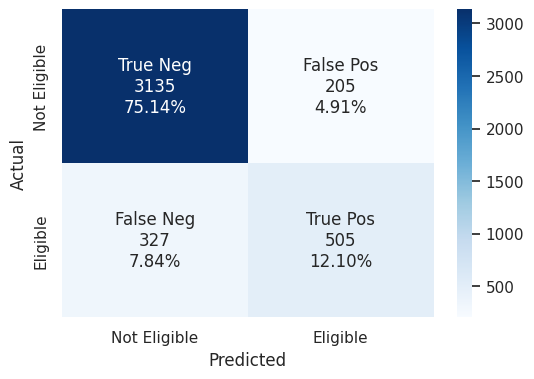

In [42]:
#Predicting for train set
y_pred_train = lg.predict(x_train)

#checking the performance on the train dataset
metrics_score(y_train, y_pred_train)

| Context                                                                           | Verdict                                     |
| --------------------------------------------------------------------------------- | ------------------------------------------- |
| **Balanced use-case** (both classes equally important)                            | Not ideal, class 1 recall needs improvement |
| **Class 0 is more important** (e.g., avoiding false positives)                    | Very good                                   |
| **Class 1 is more important** (e.g., catching all positives like fraud or cancer) | Needs improvement (recall = 0.61 is low)    |


✅ Recommendations if class 1 is important:

Try SMOTE / class weighting to balance classes.

Use threshold tuning to improve recall for class 1.

Try more complex models or feature engineering.

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1431
           1       0.75      0.59      0.66       357

    accuracy                           0.88      1788
   macro avg       0.82      0.77      0.79      1788
weighted avg       0.87      0.88      0.87      1788



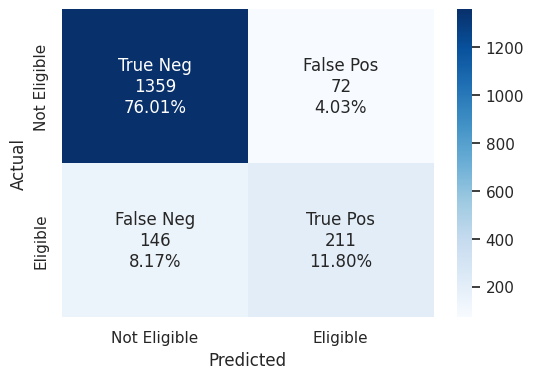

In [43]:
#Predicting for test set
y_pred_test = lg.predict(x_test)

#checking the performance on the test dataset
metrics_score(y_test, y_pred_test)

In [44]:
lg_test = model_performance_classification(lg,x_test,y_test)
lg_test

,Precision,Recall,Accuracy
0,0.824287,0.770361,0.878076


In [45]:
# Printing the coefficients of logistic regression

cols = X_scaled.columns

coef_lg = lg.coef_

pd.DataFrame(coef_lg,columns = cols).T.sort_values(by = 0, ascending = False)

,0
DEBTINC_missing_values_flag,1.157788
VALUE_missing_values_flag,0.735727
DEBTINC,0.686459
CLNO_missing_values_flag,0.326149
CLAGE_missing_values_flag,0.250206
NINQ,0.204533
MORTDUE_missing_values_flag,0.159940
REASON_HomeImp,0.114274
JOB_Sales,0.108807
VALUE,0.099661


Insights:

Features which positively affect on the defaulted rate are:

DEBTINC

NINQ

Features which negatively affect on the defaulted rate are:

MORTDUE

CLAGE

The coefficients of the logistic regression model give us the log of odds, which is hard to interpret in the real world. We can convert the log of odds into odds by taking its exponential.

In [46]:
odds = np.exp(lg.coef_[0]) # Finding the odds

# Adding the odds to a DataFrame and sorting the values
pd.DataFrame(odds, x_train.columns, columns = ['odds']).sort_values(by = 'odds', ascending = False)

,odds
DEBTINC_missing_values_flag,3.182886
VALUE_missing_values_flag,2.086999
DEBTINC,1.986668
CLNO_missing_values_flag,1.385622
CLAGE_missing_values_flag,1.284290
NINQ,1.226953
MORTDUE_missing_values_flag,1.173441
REASON_HomeImp,1.121059
JOB_Sales,1.114947
VALUE,1.104796


context for above:

| Feature        | Log-Odds Coefficient | Odds (via `np.exp`) | Interpretation                     |
| -------------- | -------------------- | ------------------- | ---------------------------------- |
| `Income`       | `1.1`                | `exp(1.1) ≈ 3.0`    | A 1-unit increase triples the odds |
| `Job_Employed` | `-0.7`               | `exp(-0.7) ≈ 0.50`  | A 1-unit increase halves the odds  |
| `LoanAmount`   | `0`                  | `exp(0) = 1.0`      | No effect on outcome               |


Insights :

The odds of defaulting for a client with high debt/income ratio is 50% higher than one with low ratio.

The odds of defaulting for a client with many recent credit inquiries is ~34% higher than one with a small number.

### **Precision recall curve**

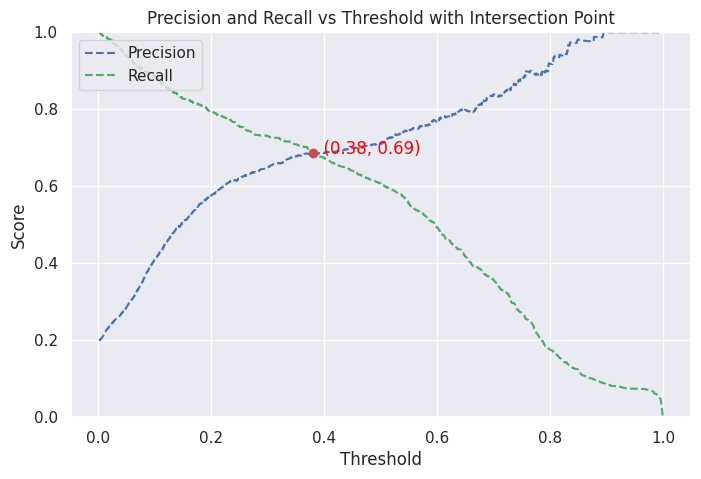

Intersection threshold: 0.3806
Precision ≈ Recall: 0.6851


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get scores and calculate precision-recall-thresholds
_scores_lg = lg.predict_proba(x_train)[:, 1]
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, _scores_lg)

# Step 1: Find index where |precision - recall| is smallest
diff = np.abs(precisions_lg[:-1] - recalls_lg[:-1])
idx = np.argmin(diff)

# Get corresponding values
best_threshold = thresholds_lg[idx]
best_precision = precisions_lg[idx]
best_recall = recalls_lg[idx]

# Step 2: Plot the curves
plt.figure(figsize=(8,5))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='Precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label='Recall')

# Step 3: Mark intersection point
plt.plot(best_threshold, best_precision, 'ro')  # red dot
plt.text(best_threshold, best_precision, f'  ({best_threshold:.2f}, {best_precision:.2f})', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.title('Precision and Recall vs Threshold with Intersection Point')
plt.grid(True)
plt.show()

# Optional: print the values
print(f"Intersection threshold: {best_threshold:.4f}")
print(f"Precision ≈ Recall: {best_precision:.4f}")


Observation:

We can see that the precision and the recall are balanced for a threshold of about 0.38.

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3340
           1       0.64      0.73      0.68       832

    accuracy                           0.86      4172
   macro avg       0.78      0.81      0.80      4172
weighted avg       0.87      0.86      0.87      4172



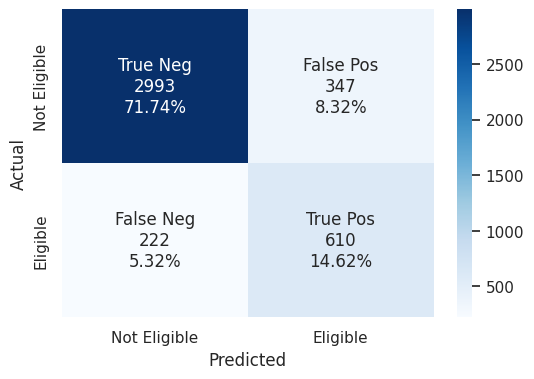

In [48]:
optimal_threshold1 = .28

y_pred_train1 = lg.predict_proba(x_train)

metrics_score(y_train, y_pred_train1[:, 1] > optimal_threshold1)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3340
           1       0.69      0.69      0.69       832

    accuracy                           0.87      4172
   macro avg       0.80      0.80      0.80      4172
weighted avg       0.87      0.87      0.87      4172



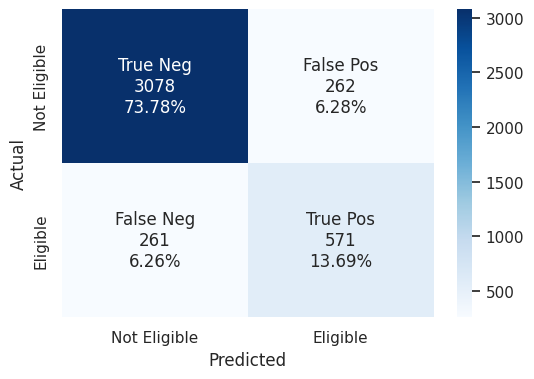

In [49]:
optimal_threshold1 = .38

y_pred_train1 = lg.predict_proba(x_train)

metrics_score(y_train, y_pred_train1[:, 1] > optimal_threshold1)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1431
           1       0.67      0.72      0.69       357

    accuracy                           0.87      1788
   macro avg       0.80      0.82      0.81      1788
weighted avg       0.88      0.87      0.87      1788



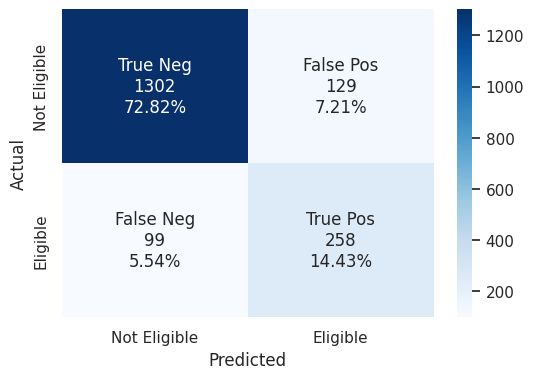

In [50]:
optimal_threshold1 = .28

y_pred_test = lg.predict_proba(x_test)

metrics_score(y_test, y_pred_test[:, 1] > optimal_threshold1)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1431
           1       0.71      0.68      0.70       357

    accuracy                           0.88      1788
   macro avg       0.82      0.81      0.81      1788
weighted avg       0.88      0.88      0.88      1788



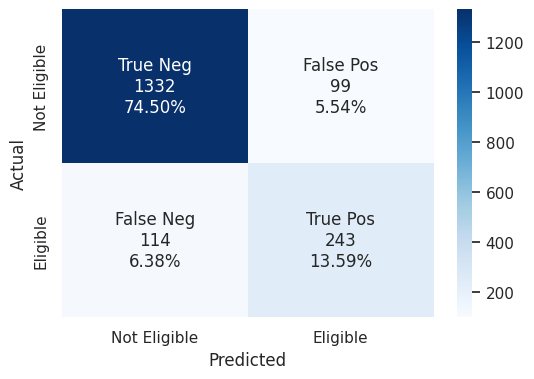

In [51]:
optimal_threshold1 = .38

y_pred_test = lg.predict_proba(x_test)

metrics_score(y_test, y_pred_test[:, 1] > optimal_threshold1)

### **DECISION TREE**

In [52]:
#copying df to another variable
data = df.copy()

In [53]:
# Separating the target variable and other variables
Y = data.BAD
X = data.drop(columns = ['BAD'])

# Creating the list of columns for which we need to create the dummy variables
to_get_dummies_for = ['REASON', 'JOB']

# Creating dummy variables
X = pd.get_dummies(data = X, columns = to_get_dummies_for, drop_first = True)

In [54]:
# Split the data into training and test set (We use Stratify = 1 because data is unbalanced)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [55]:
#Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8}
dt = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

In [56]:
#fitting Decision tree model
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



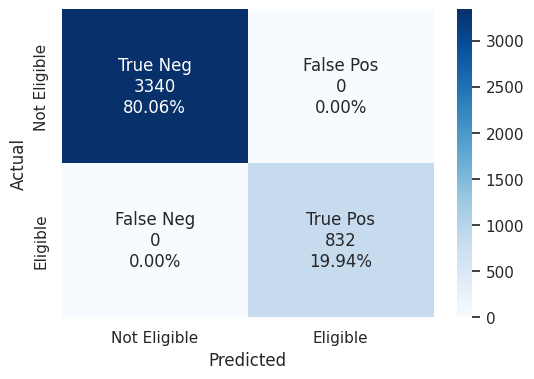

In [57]:
# Checking performance on the training data

y_train_pred_dt = dt.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1431
           1       0.66      0.59      0.62       357

    accuracy                           0.86      1788
   macro avg       0.78      0.76      0.77      1788
weighted avg       0.85      0.86      0.85      1788



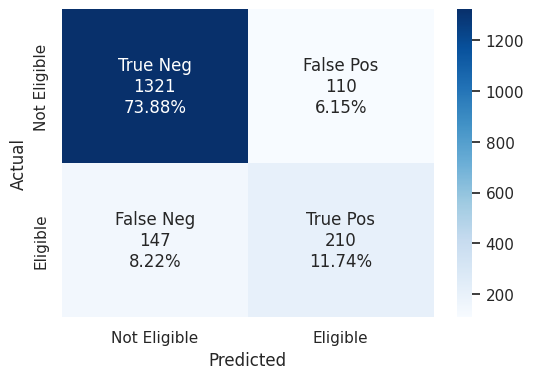

In [58]:
# Checking performance on the testing data

y_test_pred_dt = dt.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [59]:
dtree = model_performance_classification(dt,x_test,y_test)
dtree

,Precision,Recall,Accuracy
0,0.778057,0.755683,0.856264


Observations:

The Decision Tree works not so well on the test data as the recall is 0.59 in comparison to 1.00 for the training dataset, i.e., the Decision
Tree is overfitting the training data.

The precision on the test data suggests that there's a 34% chance that the model will predict that a client is going to default even though he/she would not (false positive), increasing the risk for the bank to loses income.

The recall in this model is greater than in logistical regression.

<Axes: xlabel='Importance', ylabel='None'>

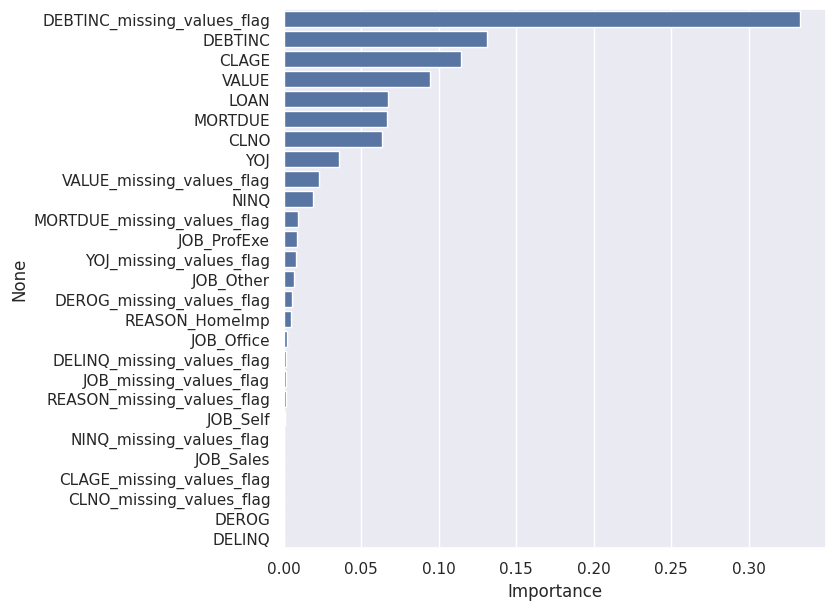

In [60]:
importances = dt.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (7, 7))
sns.barplot(x=importance_df.Importance, y=importance_df.index)

Observations:

According to the Decision Tree, DEBTINC_missing_values_flag is the most important feature, followed by DEBTINC. This signifies that applicants who are at risk of default a loan have high debt and relatively low income

The other important features CLNO, LOAN, CLAGE, VALUE, MORTDUE,CLNO.

### **Decision Tree - Hyperparameter Tuning**


Hyperparameter tuning is tricky in the sense that there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of the model.

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.

It is an exhaustive search that is performed on the specific parameter values of a model.

The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [61]:
# Choosing the type of classifier.
d_tree_tuned = DecisionTreeClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7),
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 10)


# Fitting the GridSearch on train dataset
gridCV = gridCV.fit(x_train, y_train)


# Setting the clf to the best combination of parameters
d_tree_tunedr = gridCV.best_estimator_


# Fitting the best algorithm to the data.
d_tree_tunedr.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=np.int64(5),
                       min_samples_leaf=10, random_state=1)

###**Initializes GridSearchCV:**

Performs exhaustive search over the hyperparameter grid.

Uses 10-fold cross-validation.

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      3340
           1       0.62      0.80      0.70       832

    accuracy                           0.86      4172
   macro avg       0.78      0.84      0.80      4172
weighted avg       0.88      0.86      0.87      4172



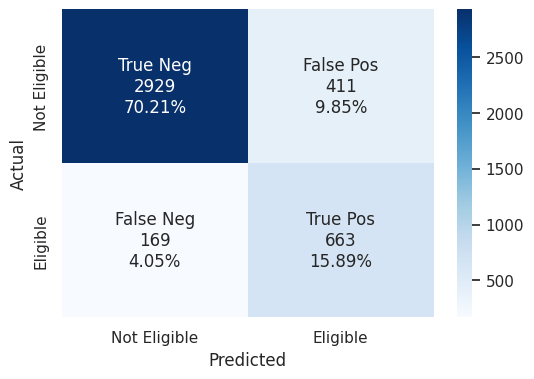

In [62]:
# Checking performance on the training data based on the tuned model

y_train_pred_dt = d_tree_tunedr.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1431
           1       0.61      0.76      0.67       357

    accuracy                           0.85      1788
   macro avg       0.77      0.82      0.79      1788
weighted avg       0.87      0.85      0.86      1788



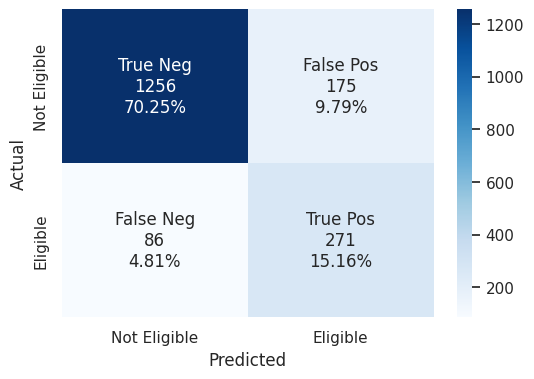

In [63]:
# Checking performance on the testing data based on the tuned model

y_test_pred_dt = d_tree_tunedr.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [64]:
dtree_tuned_test = model_performance_classification(d_tree_tunedr,x_test,y_test)
dtree_tuned_test

,Precision,Recall,Accuracy
0,0.77177,0.818406,0.854027


##**Observations:**

In comparison to the model with default values of hyperparameters, the performance on the training set has gone down significantly (1.00 to 0.74) This makes sense because we are trying to reduce overfitting.

The tuned model is performing well in comparison to the model with default values of hyperparameters: Recall increases from 0.61 to 0.74 in test data.

This model is not overfitting the training data and giving approximately the same result on the test and train datasets.

Precision has gone down significantly from .73 to .62 in comparison to the previous model which means the tuned model will give a high number of false positives, i.e., this model will predict the client is going to default even if he/she won't, and this will increases the risk of losing income.

<Axes: xlabel='Importance', ylabel='None'>

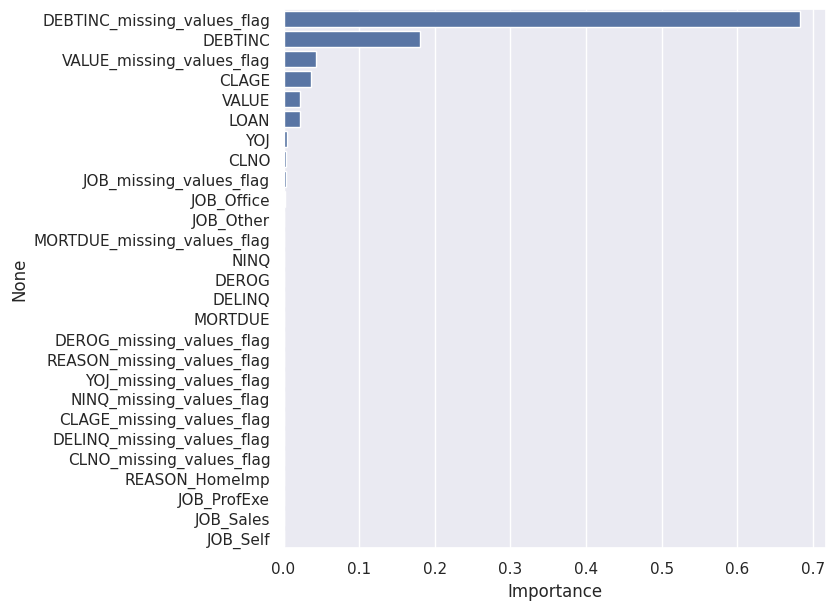

In [65]:
importances = d_tree_tunedr.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (7, 7))

sns.barplot(x=importance_df.Importance,y= importance_df.index)

Observations:

According to this model too, DEBTINC_missing_value, DEBTINC, DELINQ, CLAGE, DEROG, CLNO, MORTDUEand YOG are the most important features that describe why a client is defaulting.

The tuned model is more generalized than the default model.

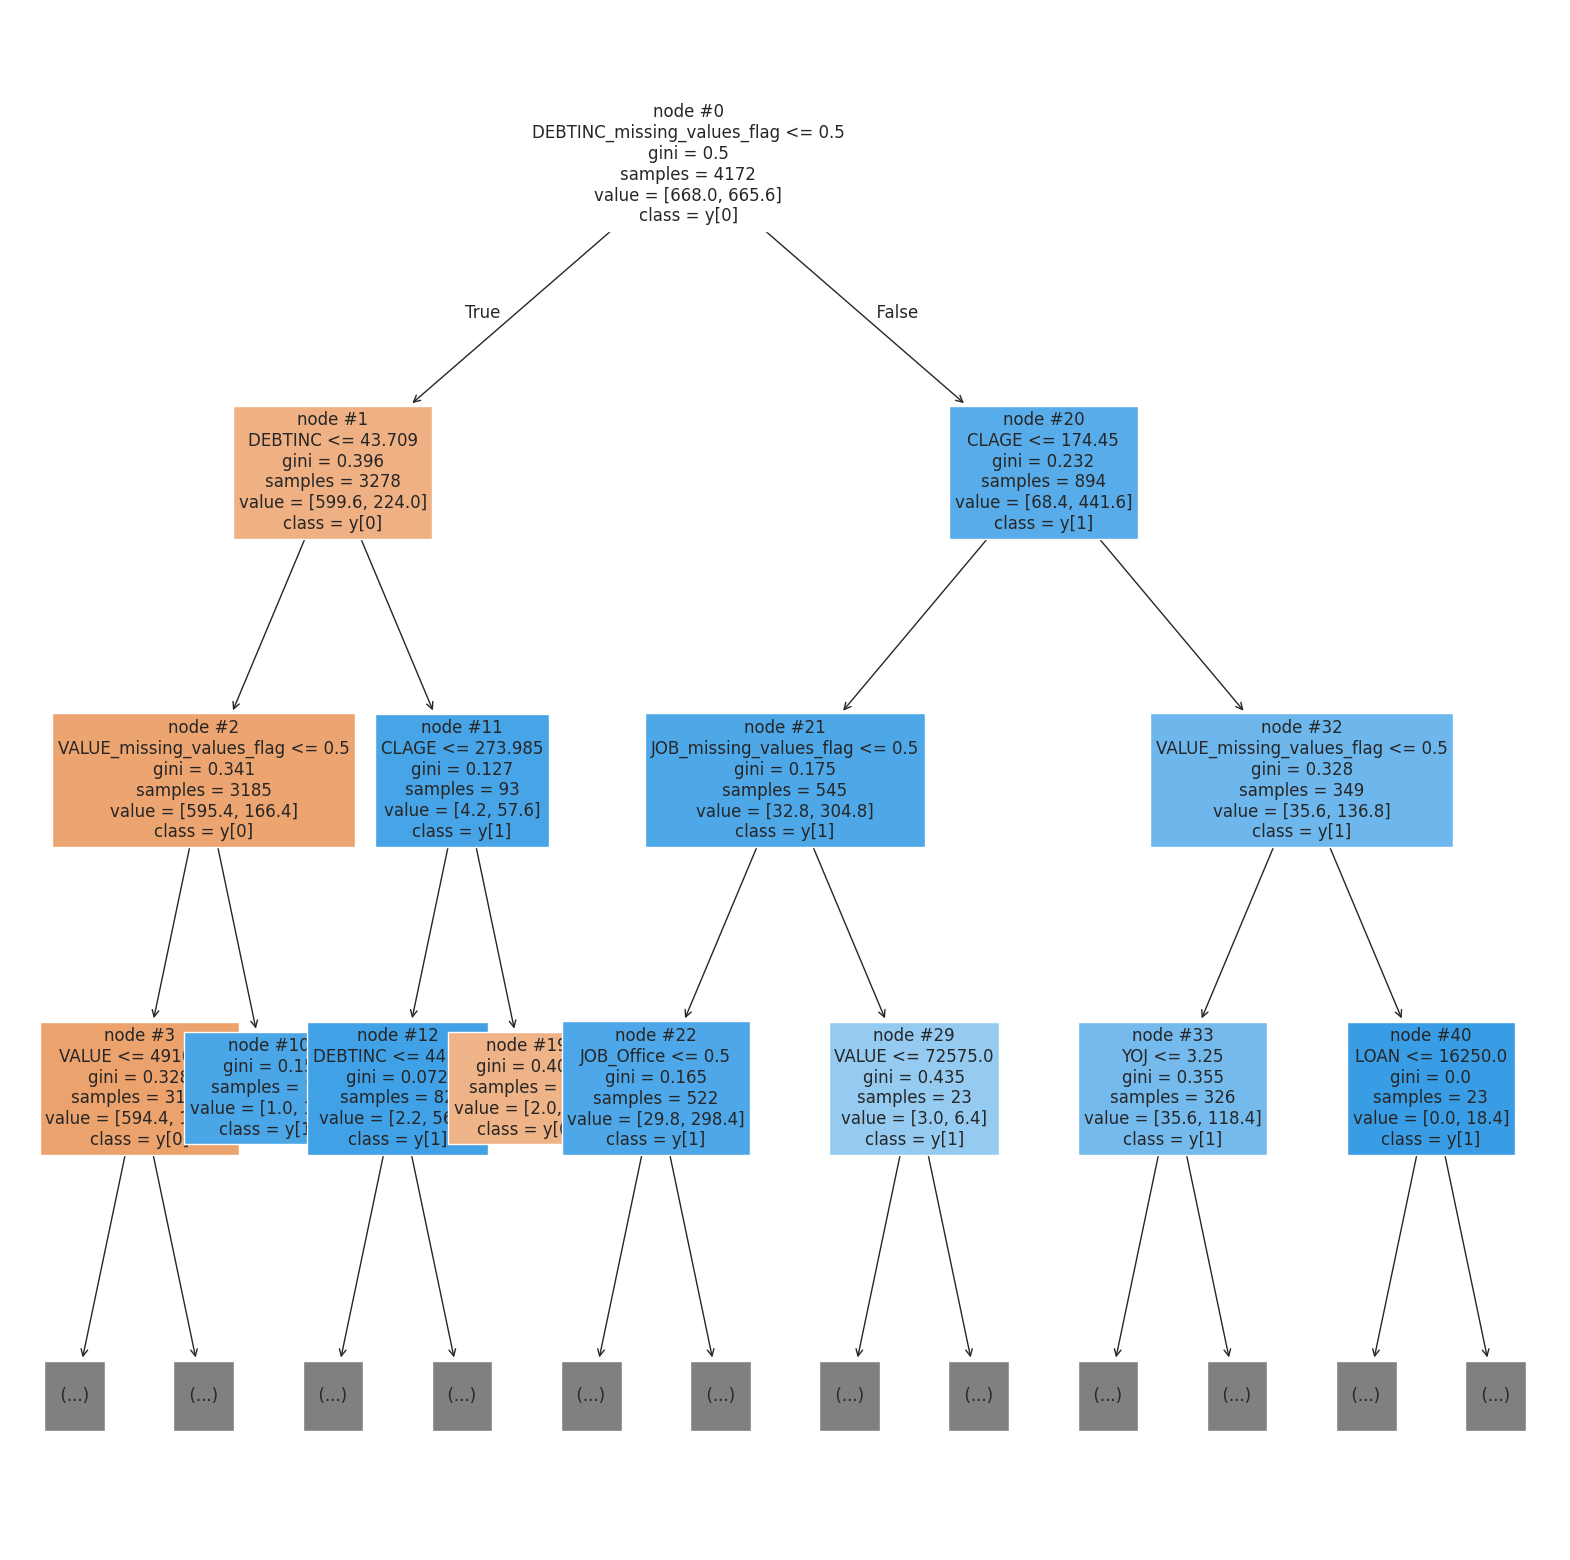

In [66]:
# Plotting the decision  tree and analyze it to build the decision rule

features = list(X.columns)

plt.figure(figsize = (20, 20))

tree.plot_tree(d_tree_tunedr, max_depth = 3, feature_names = features, filled = True, fontsize = 12, node_ids = True, class_names = True)

plt.show()

Observations:

Blue leaves represent the defult loans, i.e., y[1] and the orange leaves represent the reapy loan, i.e., y[0].

The more the number of observations in a leaf, the darker its color gets.

In [67]:
print(d_tree_tunedr.tree_.node_count)


43


##**Building a Random Forest Classifier**

Random Forest is a bagging algorithm where the base models are Decision Trees. Samples are taken from the training data and on each sample a decision tree makes a prediction.

The results from all the decision trees are combined together and the final prediction is made using voting or averaging.

In [68]:
# Defining Random forest CLassifier

rf_estimator = RandomForestClassifier(random_state = 1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



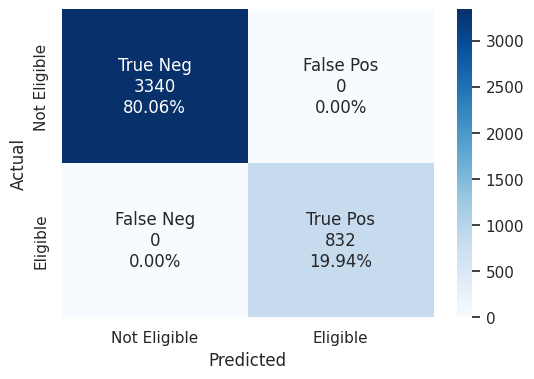

In [69]:
#Checking performance on the training data

y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1431
           1       0.79      0.68      0.73       357

    accuracy                           0.90      1788
   macro avg       0.85      0.82      0.83      1788
weighted avg       0.90      0.90      0.90      1788



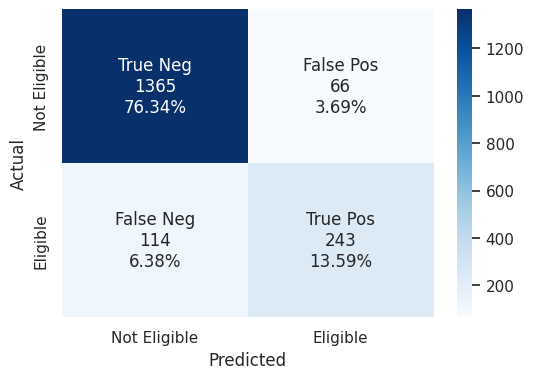

In [70]:
# Checking performance on the test data

y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [71]:
rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
rf_estimator_test

,Precision,Recall,Accuracy
0,0.854664,0.817275,0.899329


Observations:

The Random Forest is giving a 100% score for all metrics on the training dataset.

The Random Forest classifier seems to be overfitting the training data. The recall on the training data is 1, while the recall on the test data is only 68% for class 1.

Precision is good for the test data- 79%

##**Random Forest Classifier Hyperparameter Tuning**

In [72]:
# Defining Random Forest model with class weights class_weight={0: 0.2, 1: 0.8}
rf_estimator_balanced = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = 1)

# Fitting Random Forest model
rf_estimator_balanced.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



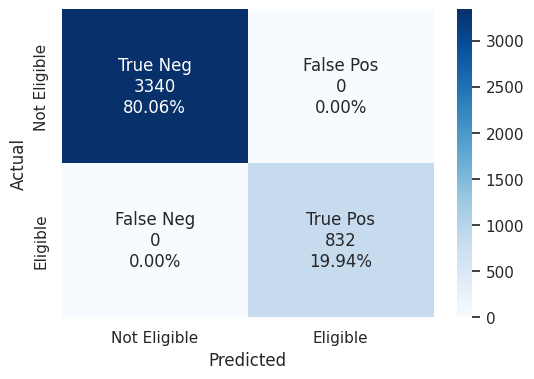

In [73]:
# Checking performance on the train data

y_pred_train_rf = rf_estimator_balanced.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1431
           1       0.78      0.64      0.71       357

    accuracy                           0.89      1788
   macro avg       0.85      0.80      0.82      1788
weighted avg       0.89      0.89      0.89      1788



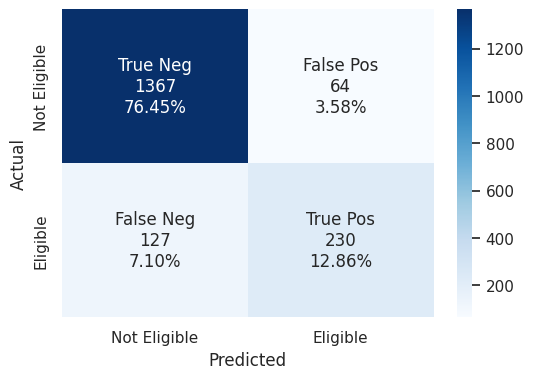

In [74]:
# Checking performance on the test data

y_pred_test_rf = rf_estimator_balanced.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [75]:
rf_estimator_balanced_test = model_performance_classification(rf_estimator_balanced,x_test,y_test)
rf_estimator_balanced_test

,Precision,Recall,Accuracy
0,0.848653,0.799767,0.893177


Observations:

The balanced random forest did not improve the model performance and also giving a 100% score for all metrics on the training dataset.
It is is also overfitted the training data.

The recall on the training data is 1, while the recall on the test data is only 64% for class 1 compared to 68% in the baseline model

Precision is good for the test data- 78%

**Tuning the Random Forest**

Using Grid search to perform hyperparameter tuning.

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.

It is an exhaustive search that is performed on the specific parameter values of a model.

The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [76]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 110, 120],
    "max_depth": [5, 6, 7],
    "max_features": [0.8, 0.9, 1]
             }

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [77]:
# Fitting the best algorithm to the training data
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=0.9,
                       random_state=7)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3340
           1       0.77      0.68      0.72       832

    accuracy                           0.90      4172
   macro avg       0.85      0.81      0.83      4172
weighted avg       0.89      0.90      0.89      4172



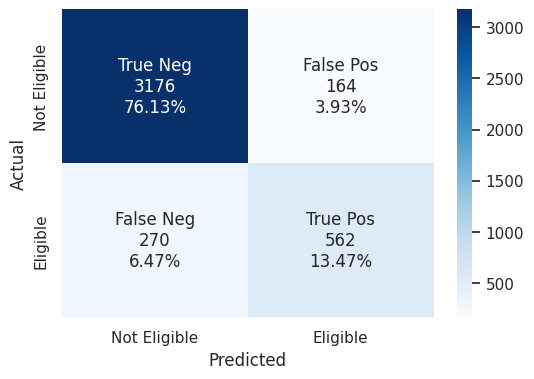

In [78]:
# Checking performance on the train data

y_pred_train_rf = rf_estimator_tuned.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1431
           1       0.75      0.61      0.67       357

    accuracy                           0.88      1788
   macro avg       0.83      0.78      0.80      1788
weighted avg       0.88      0.88      0.88      1788



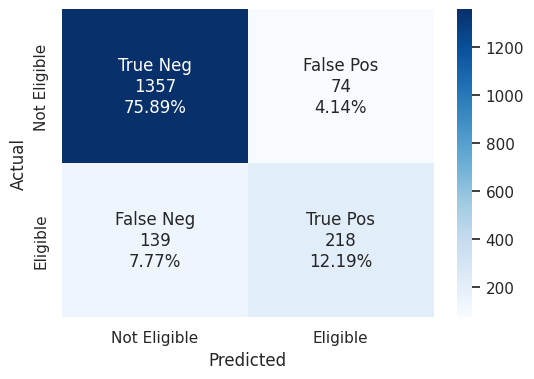

In [79]:
# Checking performance on the test data

y_pred_test_rf = rf_estimator_tuned.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [80]:
rf_estimator_tuned_test = model_performance_classification(rf_estimator_tuned,x_test,y_test)
rf_estimator_tuned_test

,Precision,Recall,Accuracy
0,0.82683,0.779466,0.880872


Observation:

The tuned random forest improves the model performance and is not giving a 100% score for all metrics on the training dataset- there is less overfitting of the training data.

The recall on the training data is 68%, while the recall on the test data is only 61% for class 1 compared to 68% in the baseline model and 64% for the balanced random forest model.

Precision for the test set is 75%, it has decreased compared to the baseline model and balanced model.

<Axes: xlabel='Importance', ylabel='None'>

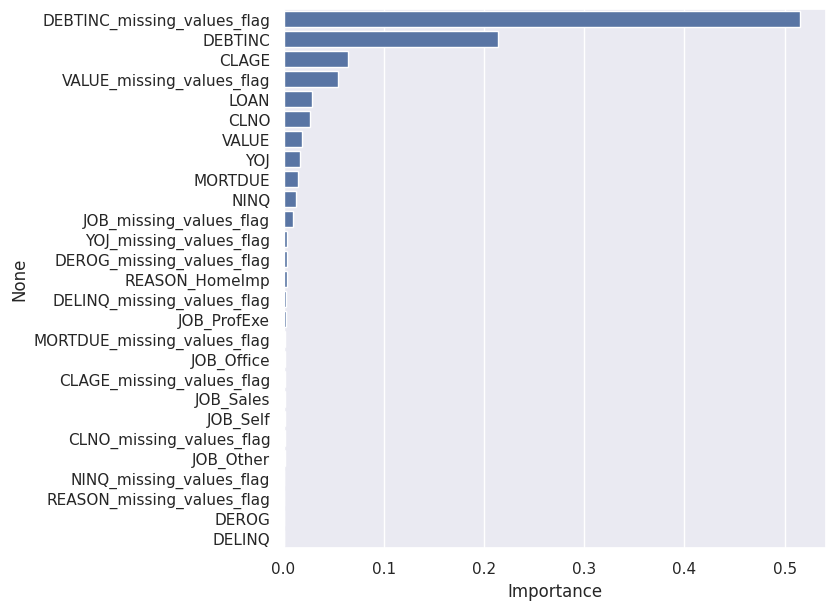

In [81]:
# Checking performace on test dataset

importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (7, 7))

sns.barplot(x=importance_df.Importance, y=importance_df.index)

##**XGBOOST CLASSIFIER**

In [82]:
#Fitting XGBoost

xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')

# Fitting the model
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00       832

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



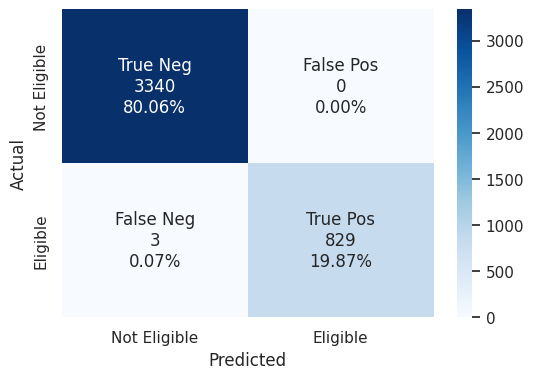

In [83]:
y_pred_train_xgb = xgb.predict(x_train)

metrics_score(y_train, y_pred_train_xgb)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.83      0.66      0.73       357

    accuracy                           0.90      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.90      0.90      1788



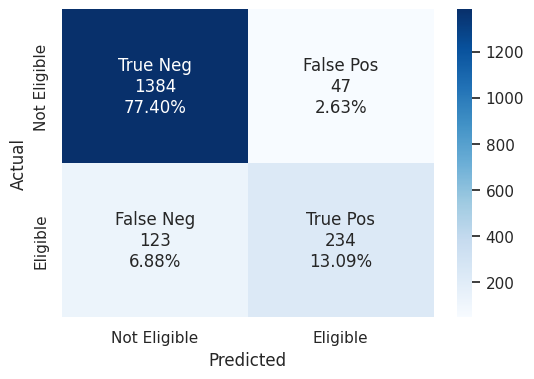

In [84]:
y_pred_test_xgb = xgb.predict(x_test)

metrics_score(y_test, y_pred_test_xgb)

In [85]:
# Model Performance on the test data
xgb_perf_test = model_performance_classification(xgb,x_test,y_test)

xgb_perf_test

,Precision,Recall,Accuracy
0,0.875561,0.811309,0.904922


###**Observation:**

The recall on the training data is 99%, while the recall on the test data is only 66% for class 1.

Precision for the test set is 87%.

It has highest recall, precision and accuracy compared to other models.

##**COMPARING MODEL PERFORMANCES**

In [86]:
def get_recall_score(model,flag=True,X_train=x_train,X_test=x_test):
    '''
    model : classifier to predict values of X

    '''
    a = [] # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    a.append(train_recall) # adding train recall to list
    a.append(test_recall) # adding test recall to list

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

    return a # returning the list with train and test scores

In [87]:
##  Function to calculate precision score
def get_precision_score(model,flag=True,X_train=x_train,X_test=x_test):
    '''
    model : classifier to predict values of X

    '''
    b = []  # defining an empty list to store train and test results
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    b.append(train_precision) # adding train precision to list
    b.append(test_precision) # adding test precision to list

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return b # returning the list with train and test scores

In [88]:
##  Function to calculate accuracy score
def get_accuracy_score(model,flag=True,X_train=x_train,X_test=x_test):
    '''
    model : classifier to predict values of X

    '''
    c = [] # defining an empty list to store train and test results
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    c.append(train_acc) # adding train accuracy to list
    c.append(test_acc) # adding test accuracy to list

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))

    return c # returning the list with train and test scores

In [89]:
# Making the list of all the model names

models = [xgb,rf_estimator_tuned, rf_estimator_balanced, rf_estimator, d_tree_tuned, dt]

# Fit the models that were not previously fitted
d_tree_tuned.fit(x_train, y_train)
dt.fit(x_train, y_train)

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy,recall and precision scores
for model in models:

     # precision score
    l = get_precision_score(model,False)
    precision_train.append(l[0])
    precision_test.append(l[1])

    # accuracy score
    j = get_accuracy_score(model,False)
    acc_train.append(j[0])
    acc_test.append(j[1])

    # recall score
    k = get_recall_score(model,False)
    recall_train.append(k[0])
    recall_test.append(k[1])

In [90]:
# Mentioning the Model names in the list.
comparison_frame = pd.DataFrame({'Model':['XGBoost classifier','Tuned Random Forest', 'Balanced Random Forest','Random Forest', 'Tuned Decision Tree', 'Decision Tree'],
                                          'Train_Accuracy': acc_train,
                                          'Test_Accuracy': acc_test,
                                          'Train_Recall': recall_train,
                                          'Test_Recall': recall_test,
                                          'Train_Precision': precision_train,
                                          'Test_Precision': precision_test})
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,XGBoost classifier,0.999281,0.904922,0.996394,0.655462,1.000000,0.832740
1,Tuned Random Forest,0.895973,0.880872,0.675481,0.610644,0.774105,0.746575
2,Balanced Random Forest,1.000000,0.893177,1.000000,0.644258,1.000000,0.782313
3,Random Forest,1.000000,0.899329,1.000000,0.680672,1.000000,0.786408
4,Tuned Decision Tree,1.000000,0.856264,1.000000,0.588235,1.000000,0.656250
5,Decision Tree,1.000000,0.856264,1.000000,0.588235,1.000000,0.656250


In [91]:
#Compare overall precision, recall, accuracy
models_test_comp_df = pd.concat(

    [
    lg_test.T, dtree.T, dtree_tuned_test.T,rf_estimator_test.T,
    rf_estimator_balanced_test.T, rf_estimator_tuned_test.T, xgb_perf_test.T
    ],

    axis = 1,
)

models_test_comp_df.columns = [
    "Logistic regresstion model",
    "Decision Tree classifier",
    "Tuned Decision Tree classifier",
    "Random Forest classifier",
    "Balanced Random Forest classifier",
    "Tuned Random Forest classifier",
    "XGBoost classifier"
    ]

In [92]:
print("Test performance comparison:")
models_test_comp_df.T

Test performance comparison:


,Precision,Recall,Accuracy
Logistic regresstion model,0.824287,0.770361,0.878076
Decision Tree classifier,0.778057,0.755683,0.856264
Tuned Decision Tree classifier,0.771770,0.818406,0.854027
Random Forest classifier,0.854664,0.817275,0.899329
Balanced Random Forest classifier,0.848653,0.799767,0.893177
Tuned Random Forest classifier,0.826830,0.779466,0.880872
XGBoost classifier,0.875561,0.811309,0.904922


Refined insights:

Models with the higher test accuracy are the XGBoost Classifier ~.91.

All models overfit the training data with the exception of the Tuned Random Forest and XGBoost Classifier.

The highest recall (.82) belongs Random Forest and XGBoost Classifier. Higher than decision tree model.

Precision in XGBoost Classifier models are high (~.88). Is also higher than Decision Tree models and Random Forest model.

##Model Interpretability check with Shapley Values

In [93]:
#Initialize Shap

# Need to load JS vis in the notebook
shap.initjs()

In [94]:
#Local Interpretation using SHAP (for prediction at id number 4776)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_train)

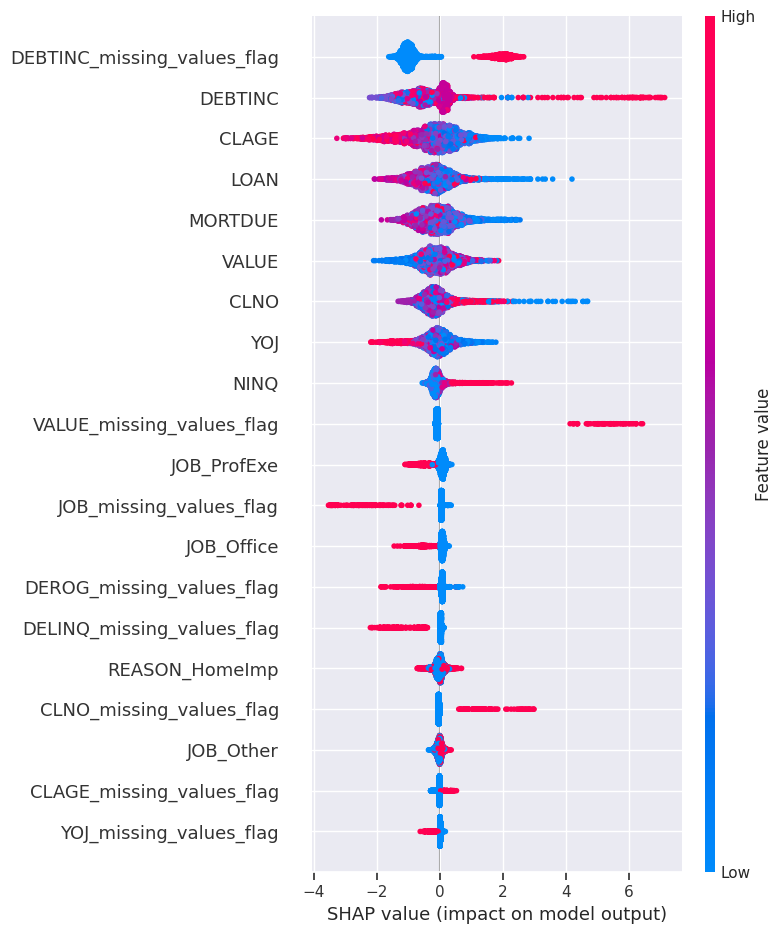

In [95]:
shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns)

Observations:

High DEBTINC values are on the right side primarily because they contribute positively to identify defaulter.

So, the prominent feature that is the most impactful in the change to default on a loan is the debt-to-income ratio.

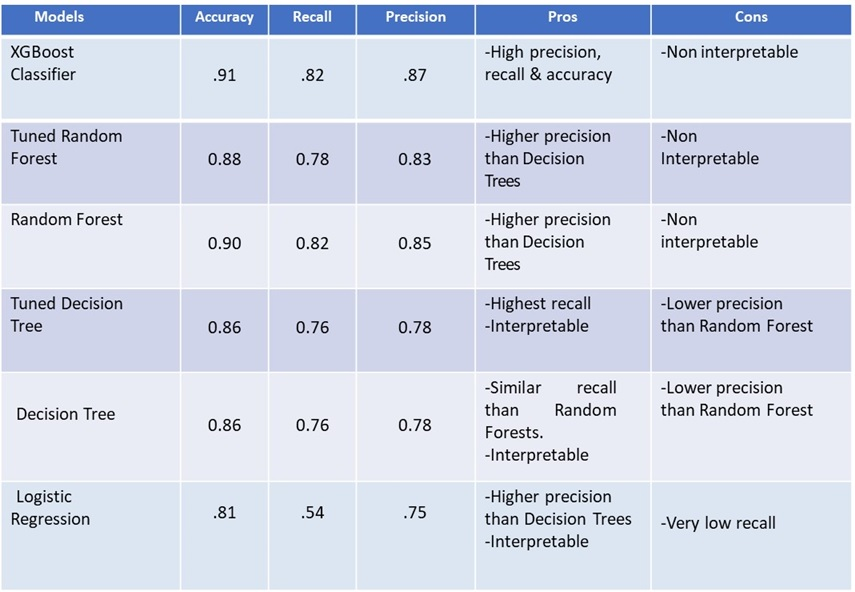

##**Executive Summary**

Final proposed model specifications:

* 20% of the clients in the dataset are loan defaulters (BAD = 1), while the remaining 80% are non-defaulters (BAD = 0).
* Multiple classification models were tested to identify key factors contributing to loan default.
* The analysis reveals that financial background variables are more influential than job profile, reason for the loan, mortgage amount, property value, or the requested loan amount.
* Among all features, the debt-to-income ratio was identified as the most impactful predictor of loan default.
* Other important features include CLAGE, VALUE, LOAN, MORTDUE, and CLNO — all of which significantly influence the probability of default.
* The best-performing model was the XGBoost Classifier, achieving:
* Recall (Class 1): 82%
* Precision: 87%
* Accuracy: 91%
* These performance metrics meet the desired evaluation criteria, especially for handling imbalanced classes.
* The model’s high recall and high precision ensure reliable detection of defaulters while minimizing false negatives.
* While XGBoost delivers high accuracy, it sacrifices the interpretability offered by simpler models like decision trees.
* Nonetheless, the model is robust and does not require further tuning at this stage.
* The bank can confidently use this model to proactively identify clients at risk of default.
* For future improvement, other algorithms such as KNN or additional boosting techniques can be explored, with a focus on maximizing recall.
* Maximizing recall is essential in the banking context to reduce the number of false negatives, i.e., missed defaulters (true Class 1 cases).


In [96]:
from sklearn.metrics import roc_auc_score

# Calculate AUC-ROC score on the test set
y_pred_proba_xgb = xgb.predict_proba(x_test)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"AUC-ROC Score for XGBoost Classifier: {auc_roc_xgb:.4f}")

AUC-ROC Score for XGBoost Classifier: 0.9417


In [97]:
from sklearn.metrics import roc_auc_score

auc_roc_scores = {}

for model in models:
    model_name = type(model).__name__
    if model_name == 'DecisionTreeClassifier' and model.max_depth is not None:
        model_name = 'Tuned Decision Tree'
    if model_name == 'RandomForestClassifier' and model.class_weight is not None:
        model_name = 'Balanced Random Forest'
    if model_name == 'RandomForestClassifier' and model.max_depth is not None:
         model_name = 'Tuned Random Forest'
    if model_name == 'XGBClassifier':
        model_name = 'XGBoost Classifier'

    y_pred_proba = model.predict_proba(x_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_roc_scores[model_name] = auc_roc

auc_roc_df = pd.DataFrame(auc_roc_scores.items(), columns=['Model', 'AUC-ROC Score'])
print("AUC-ROC Scores for all Models:")
display(auc_roc_df.sort_values(by='AUC-ROC Score', ascending=False))

AUC-ROC Scores for all Models:


,Model,AUC-ROC Score
2,Balanced Random Forest,0.946669
3,RandomForestClassifier,0.943569
0,XGBoost Classifier,0.941713
1,Tuned Random Forest,0.902094
4,DecisionTreeClassifier,0.755683
